#Import Libraries

In [1]:
from keras.datasets import cifar10
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, Adadelta
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf

#Classes and Functions

In [2]:
class Data(object):
  def __init__(self):
    (self.x_train, self.y_train), (self.x_test, self.y_test) = cifar10.load_data()

  def normalize(self):
    self.x_train = self.x_train / 255
    self.x_test = self.x_test / 255

  def flatten(self):
    self.x_train = self.x_train.reshape([self.x_train.shape[0], -1])
    self.x_test = self.x_test.reshape([self.x_test.shape[0], -1])
    self.x_train = self.x_train.astype('float32')
    self.x_test = self.x_test.astype('float32')
    self.y_test = self.y_test.astype('float32')
    self.y_train = self.y_train.astype('float32')

  def one_hot(self):
    self.y_train = to_categorical(self.y_train)
    self.y_test = to_categorical(self.y_test)

  def get_data(self):
    return self.x_train, self.y_train, self.x_test, self.y_test

In [3]:
class Show_Image(object):
  def __init__(self, data, label):
    self.fig = plt.figure(figsize = (15, 10))
    self.data = data
    self.label = label
    self.show()

  def show(self):
    for i in range(10):
      self.fig.add_subplot(1, 10 ,i + 1)
      plt.imshow(self.data[i])
      plt.axis('off')
      plt.title(self.labels_name(self.label[i]))

  def labels_name(self, index):
    labels_name = {0:'airplane', 1:'automobile',
                 2:'bird', 3:'cat',
                 4:'deer', 5:'dog',
                 6:'frog', 7:'horse',
                 8:'ship', 9:'truck'}
    return labels_name.get(index[0])

In [4]:
class MLP(object):
  def __init__(self):
    self.model = Sequential()

  def add_layer(self, activation=''):
    if activation != '':
      self.model.add(Dense(256, activation=activation, input_dim=3072))
      self.model.add(Dense(256, activation=activation))
      self.model.add(Dense(256, activation=activation))
    else:
      self.model.add(Dense(256, input_dim=3072))
      self.model.add(Dense(256))
      self.model.add(Dense(256))
    self.model.add(Dense(10, activation='softmax'))

  def Compile(self, loss='', optimizer=''):
    if loss != '' or optimizer != '':
      if loss != '':
        self.model.compile(loss=loss, metrics=['accuracy'])
      if optimizer != '':
        self.model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    else:
      self.model.compile(loss='mse', metrics=['accuracy'])

  def Fit(self, x_train, y_train, epochs, batch_size, validation_split):
    return self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                          validation_split=validation_split, verbose=0)

  def Evaluate(self, x_test, y_test, batch_size):
    return self.model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)

  def Predict(self, x_test):
    return self.model.predict(x_test, verbose=0)

In [5]:
class CNN_MLP(object):
  def __init__(self):
    self.model = Sequential()
  
  def add_mlp(self, activation, state='', rate=0.2):
    if state == 'dropout':
      self.model.add(Flatten())
      self.model.add(Dense(256, activation=activation))
      self.model.add(Dropout(rate))
      self.model.add(BatchNormalization())
      self.model.add(Dense(256, activation=activation))
      self.model.add(Dropout(rate))
      self.model.add(BatchNormalization())
      self.model.add(Dense(256, activation=activation))
      self.model.add(Dropout(rate))
      self.model.add(BatchNormalization())
      self.model.add(Dense(10, activation='softmax'))
    elif state == 'pooling':
      self.model.add(Flatten())
      self.model.add(Dense(256, activation=activation))
      self.model.add(BatchNormalization())
      self.model.add(Dense(256, activation=activation))
      self.model.add(BatchNormalization())
      self.model.add(Dense(256, activation=activation))
      self.model.add(BatchNormalization())
      self.model.add(Dense(10, activation='softmax'))
    else:
      self.model.add(Flatten())
      self.model.add(Dense(256, activation=activation))
      self.model.add(Dense(256, activation=activation))
      self.model.add(Dense(256, activation=activation))
      self.model.add(Dense(10, activation='softmax'))

  def add_cnn(self, filters, kernel):
    self.model.add(Conv2D(filters, kernel_size=kernel, activation="relu", input_shape=(32,32,3)))
    self.model.add(Conv2D(filters/2, kernel_size=kernel, activation="relu"))
    self.model.add(Conv2D(filters/4, kernel_size=kernel, activation="relu"))

  def add_pooling_batch(self, filters, kernel, a):
    self.model.add(Conv2D(filters, kernel_size=kernel, activation="relu", input_shape=(32,32,3)))
    self.model.add(BatchNormalization())
    self.model.add(Conv2D(filters/2, kernel_size=kernel, activation="relu"))
    self.model.add(BatchNormalization())
    self.model.add(Conv2D(filters/4, kernel_size=kernel, activation="relu"))
    self.model.add(BatchNormalization())
    self.model.add(MaxPooling2D(pool_size=(a, a)))

  def add_dropout(self, filters, kernel, a, rate):
    self.model.add(Conv2D(filters, kernel_size=kernel, activation="relu", input_shape=(32,32,3)))
    self.model.add(Dropout(rate))
    self.model.add(BatchNormalization())
    self.model.add(Conv2D(filters/2, kernel_size=kernel, activation="relu"))
    self.model.add(Dropout(rate))
    self.model.add(BatchNormalization())
    self.model.add(Conv2D(filters/4, kernel_size=kernel, activation="relu"))
    self.model.add(Dropout(rate))
    self.model.add(BatchNormalization())
    self.model.add(MaxPooling2D(pool_size=(a, a)))

  def Compile(self, optimizer, loss):
    self.model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  def Fit(self, x_train, y_train, epochs, batch_size, validation_split, callback=[]):
    if len(callback) != 0:
      return self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                            validation_split=validation_split, callbacks=callback, verbose=0)
    else:
      return self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                            validation_split=validation_split, verbose=0)
    
  def Evaluate(self, x_test, y_test, batch_size):
    return self.model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)

  def Predict(self, x_test):
    return self.model.predict(x_test, verbose=0)

  def summary(self):
    return self.model.summary()

In [35]:
def Plot_Accuracy(history, hyper, name):
  fig, axs = plt.subplots(ncols=2, nrows=len(history), figsize=(9, 10))
  if len(history) == 1:
    axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    axs[0].plot(history[0].history['loss'])
    axs[0].plot(history[0].history['val_loss'])
    axs[0].set_title(f'{name} is {hyper[0]}')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'validation'], loc='upper left')
    axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    axs[1].plot(history[0].history['accuracy'])
    axs[1].plot(history[0].history['val_accuracy'])
    axs[1].set_title(f'{name} is {hyper[0]}')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'validation'], loc='upper left')
  else:
    for i in range(len(history)):
      axs[i, 0].yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
      axs[i, 0].plot(history[i].history['loss'])
      axs[i, 0].plot(history[i].history['val_loss'])
      axs[i, 0].set_title(f'{name} is {hyper[i]}')
      axs[i, 0].set_ylabel('loss')
      axs[i, 0].set_xlabel('epoch')
      axs[i, 0].legend(['train', 'validation'], loc='upper left')
      axs[i, 1].yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
      axs[i, 1].plot(history[i].history['accuracy'])
      axs[i, 1].plot(history[i].history['val_accuracy'])
      axs[i, 1].set_title(f'{name} is {hyper[i]}')
      axs[i, 1].set_ylabel('accuracy')
      axs[i, 1].set_xlabel('epoch')
      axs[i, 1].legend(['train', 'validation'], loc='upper left')
  fig.tight_layout()
  plt.show()

In [7]:
def Convert_To_Label(y):
  y_new = []
  for i in range(len(y)):
    y_new.append(y[i].argmax() + 1)
  return y_new

#Data Loading

In [8]:
dataset = Data()
x_train, y_train, x_test, y_test = dataset.get_data()

170498071/170498071 [==============================] - 2s 0us/step


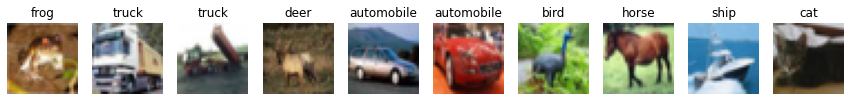

In [ ]:
Show_Image(x_train, y_train)

In [9]:
dataset.normalize()
dataset.one_hot()
x_train_CNN, y_train_CNN, x_test_CNN, y_test_CNN = dataset.get_data()
dataset.flatten()
x_train, y_train, x_test, y_test = dataset.get_data()

#MLP

In [ ]:
batch_size = [32, 64, 256]
activation = ['relu', 'elu', 'tanh']
loss = ['categorical_crossentropy', 'mse']
optimizers = [Adam(learning_rate=0.01), SGD(learning_rate=0.01)]

##1) Find best batch size

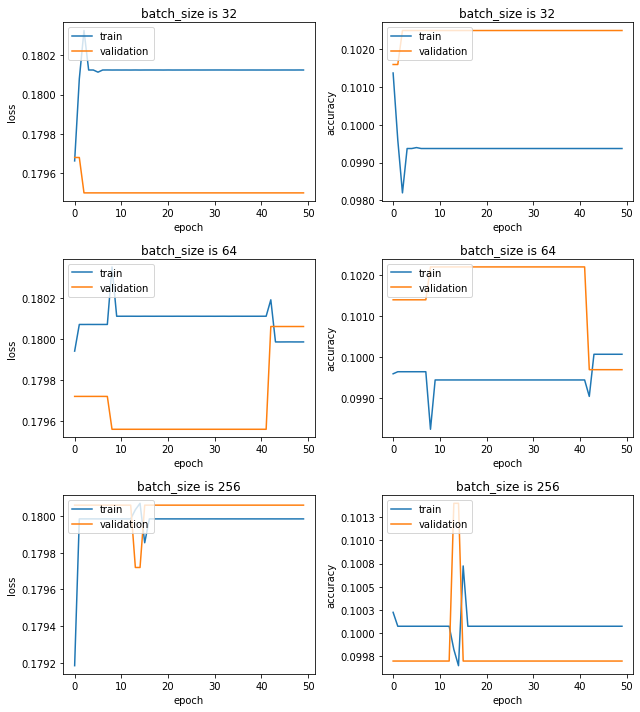

Best batch size is 32
Test data accuracy is 0.10000000149011612
Test data loss is 0.1799999624490738


array([[   0,    0,    0,    0, 1000,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 1000,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 1000,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 1000,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 1000,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 1000,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 1000,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 1000,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 1000,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 1000,    0,    0,    0,    0,    0]])

In [ ]:
scores = []
losses = []
histories = []
for bs in batch_size:
  mlp = MLP()
  mlp.add_layer()
  mlp.Compile()
  histories.append(mlp.Fit(x_train, y_train, epochs=50, batch_size=bs, validation_split=0.2))
  acloss = mlp.Evaluate(x_test, y_test, batch_size=128)
  losses.append(acloss[0])
  scores.append(acloss[1])
Plot_Accuracy(histories, batch_size, 'batch_size')
best_bs = batch_size[scores.index(max(scores))]
print(f'Best batch size is {best_bs}')
print(f'Test data accuracy is {max(scores)}')
print(f'Test data loss is {losses[scores.index(max(scores))]}')
confusion_matrix(Convert_To_Label(y_test), Convert_To_Label(mlp.Predict(x_test)))

##2) Find best activation function

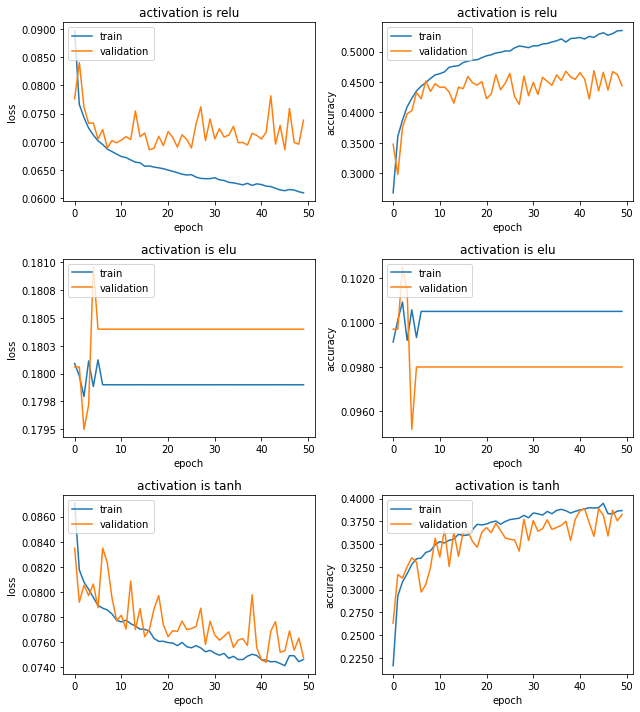

Best activation function is relu
Test data accuracy is 0.4440000057220459
Test data loss is 0.07397466897964478


array([[412,  39,  91,  63,  46,  24,  37,  68, 151,  69],
       [ 50, 435,  19,  72,  45,  29,  30,  48,  74, 198],
       [113,  31, 207,  97, 230,  65, 116,  86,  35,  20],
       [ 26,  36,  78, 258, 114, 147, 163,  90,  34,  54],
       [ 57,  11, 120,  78, 417,  38, 128,  97,  32,  22],
       [ 19,  32,  91, 218, 118, 218, 127, 110,  48,  19],
       [ 11,  15,  93, 119, 175,  48, 445,  41,  23,  30],
       [ 54,  30,  48,  56, 155,  57,  78, 444,  23,  55],
       [124,  65,  28,  74,  33,  15,  14,  14, 520, 113],
       [ 57, 156,  18,  40,  38,  31,  40,  62,  73, 485]])

In [ ]:
scores = []
losses = []
histories = []
for act in activation:
  mlp = MLP()
  mlp.add_layer(activation=act)
  mlp.Compile()
  histories.append(mlp.Fit(x_train, y_train, epochs=50, batch_size=best_bs, validation_split=0.2))
  acloss = mlp.Evaluate(x_test, y_test, batch_size=128)
  losses.append(acloss[0])
  scores.append(acloss[1])
Plot_Accuracy(histories, activation, 'activation')
best_act = activation[scores.index(max(scores))]
print(f'Best activation function is {best_act}')
print(f'Test data accuracy is {max(scores)}')
print(f'Test data loss is {losses[scores.index(max(scores))]}')
confusion_matrix(Convert_To_Label(y_test), Convert_To_Label(mlp.Predict(x_test)))

##3) Find best loss function

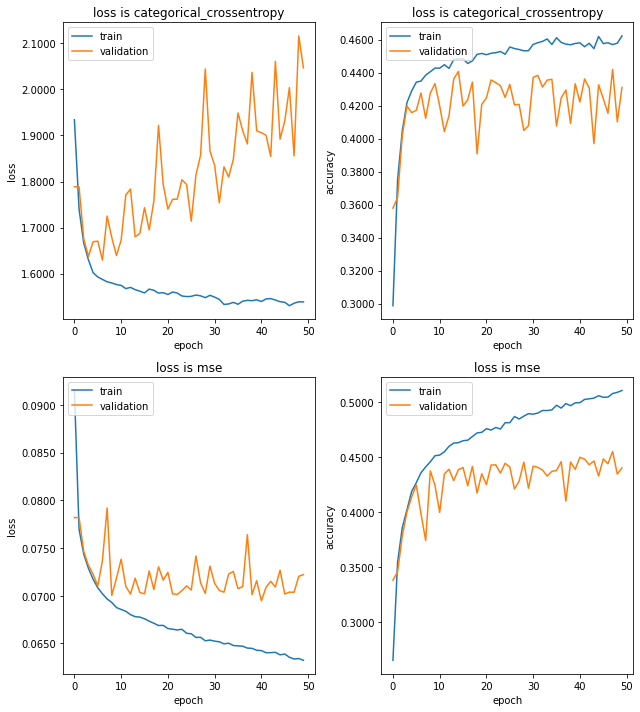

Best loss function is categorical_crossentropy
Test data accuracy is 0.44609999656677246
Test data loss is 1.7893846035003662


array([[489,  24,  91,  14,  35,  26,  23,  41, 223,  34],
       [ 72, 464,  31,  20,  21,  44,  21,  35, 128, 164],
       [ 77,  28, 391,  44, 104,  96,  99,  82,  61,  18],
       [ 39,  20, 145, 160,  54, 257, 122,  88,  54,  61],
       [ 63,  15, 239,  27, 332,  63, 123,  85,  32,  21],
       [ 26,  25, 129,  97,  48, 418,  81,  99,  41,  36],
       [ 20,  22, 135,  78, 120,  83, 459,  29,  23,  31],
       [ 63,  26,  69,  30,  79, 106,  42, 516,  19,  50],
       [ 99,  55,  16,   9,  16,  50,   4,  14, 681,  56],
       [ 82, 140,  16,  20,  14,  22,  22,  68, 117, 499]])

In [ ]:
scores = []
losses = []
histories = []
for l in loss:
  mlp = MLP()
  mlp.add_layer(activation=best_act)
  mlp.Compile(loss=l)
  histories.append(mlp.Fit(x_train, y_train, epochs=50, batch_size=best_bs, validation_split=0.2))
  acloss = mlp.Evaluate(x_test, y_test, batch_size=128)
  losses.append(acloss[0])
  scores.append(acloss[1])
Plot_Accuracy(histories, loss, 'loss')
best_loss = loss[scores.index(max(scores))]
print(f'Best loss function is {best_loss}')
print(f'Test data accuracy is {max(scores)}')
print(f'Test data loss is {losses[scores.index(max(scores))]}')
confusion_matrix(Convert_To_Label(y_test), Convert_To_Label(mlp.Predict(x_test)))

##4) Find best optimizer

<ipython-input-97-10c2690a8aae>:18: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


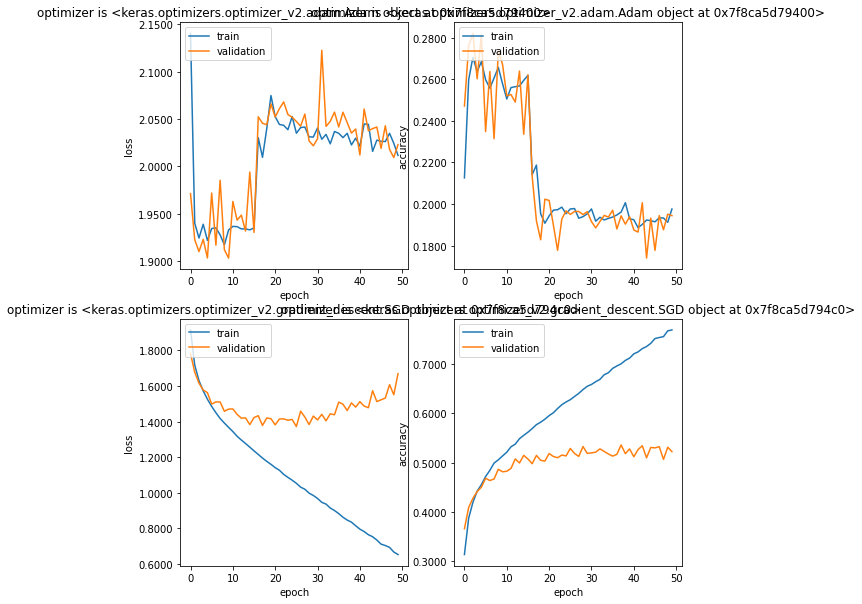

Best optimizer is <keras.optimizers.optimizer_v2.gradient_descent.SGD object at 0x7f8ca5d794c0>
Test data accuracy is 0.5289999842643738
Test data loss is 1.6231434345245361


array([[510,  57,  74,  17,  43,  10,  21,  32, 158,  78],
       [ 21, 712,   7,  19,   3,   9,   7,  15,  68, 139],
       [ 61,  36, 404,  59, 138,  51, 109,  84,  28,  30],
       [ 24,  67,  90, 321,  63, 140, 103,  64,  47,  81],
       [ 37,  23, 131,  45, 440,  35, 104, 108,  41,  36],
       [ 17,  31,  82, 220,  67, 328,  73,  95,  38,  49],
       [ 10,  46,  50,  69,  84,  30, 619,  34,  22,  36],
       [ 27,  27,  34,  40,  69,  44,  27, 639,  14,  79],
       [ 46, 103,  14,  10,  11,   5,   9,  14, 716,  72],
       [ 31, 204,  11,  21,  11,   6,  14,  40,  61, 601]])

In [ ]:
scores = []
losses = []
histories = []
for op in optimizers:
  mlp = MLP()
  mlp.add_layer(activation=best_act)
  mlp.Compile(loss=best_loss, optimizer=op)
  histories.append(mlp.Fit(x_train, y_train, epochs=50, batch_size=best_bs, validation_split=0.2))
  acloss = mlp.Evaluate(x_test, y_test, batch_size=128)
  losses.append(acloss[0])
  scores.append(acloss[1])
Plot_Accuracy(histories, optimizers, 'optimizer')
best_op = optimizers[scores.index(max(scores))]
print(f'Best optimizer is {best_op}')
print(f'Test data accuracy is {max(scores)}')
print(f'Test data loss is {losses[scores.index(max(scores))]}')
confusion_matrix(Convert_To_Label(y_test), Convert_To_Label(mlp.Predict(x_test)))

In [10]:
best_bs = 32
best_act = 'relu'
best_loss = 'categorical_crossentropy'
best_op = SGD(learning_rate=0.01)

# CNN+MLP

In [11]:
kernel = [2, 3]
filters = [32, 64, 128]
pool_size = [2, 3]
rate = [0.2, 0.3, 0.4]

##1) Just Conv2D

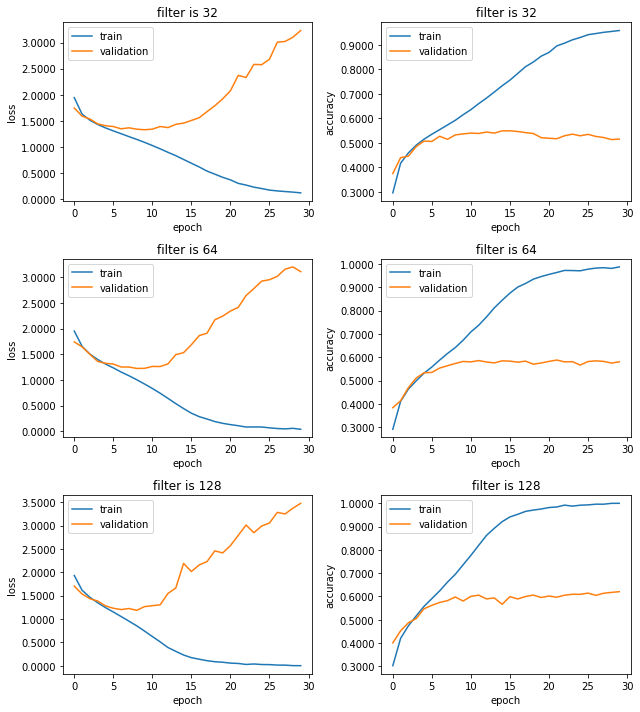

Best filter size is 128
Test data accuracy is 0.6186000108718872
Test data loss is 3.5010156631469727


array([[679,  28,  54,  22,  24,   8,  19,  13, 106,  47],
       [ 38, 726,  15,  11,   4,   8,  12,   9,  53, 124],
       [ 66,   7, 506,  89, 111,  66,  59,  60,  24,  12],
       [ 28,  13,  81, 439,  79, 163,  89,  56,  22,  30],
       [ 29,   5, 116,  83, 551,  46,  67,  81,  14,   8],
       [ 18,   4,  63, 189,  81, 491,  50,  78,  12,  14],
       [ 14,   9,  60,  78,  81,  37, 676,  12,  14,  19],
       [ 29,   5,  40,  68,  75,  66,  10, 676,   5,  26],
       [ 92,  44,  15,  17,  12,  10,   8,   8, 759,  35],
       [ 47, 127,  11,  31,   5,  11,  15,  18,  52, 683]])

In [13]:
scores = []
losses = []
histories = []
for f in filters:
  cnn_mlp = CNN_MLP()
  cnn_mlp.add_cnn(f, 3)
  cnn_mlp.add_mlp(best_act, '')
  cnn_mlp.Compile(best_op, best_loss)
  histories.append(cnn_mlp.Fit(x_train_CNN, y_train_CNN, epochs=30,
                               batch_size=best_bs, validation_split=0.2))
  acloss = cnn_mlp.Evaluate(x_test_CNN, y_test_CNN, batch_size=128)
  losses.append(acloss[0])
  scores.append(acloss[1])
Plot_Accuracy(histories, filters, 'filter')
best_filter = filters[scores.index(max(scores))]
print(f'Best filter size is {best_filter}')
print(f'Test data accuracy is {max(scores)}')
print(f'Test data loss is {losses[scores.index(max(scores))]}')
confusion_matrix(Convert_To_Label(y_test_CNN), Convert_To_Label(cnn_mlp.Predict(x_test_CNN)))

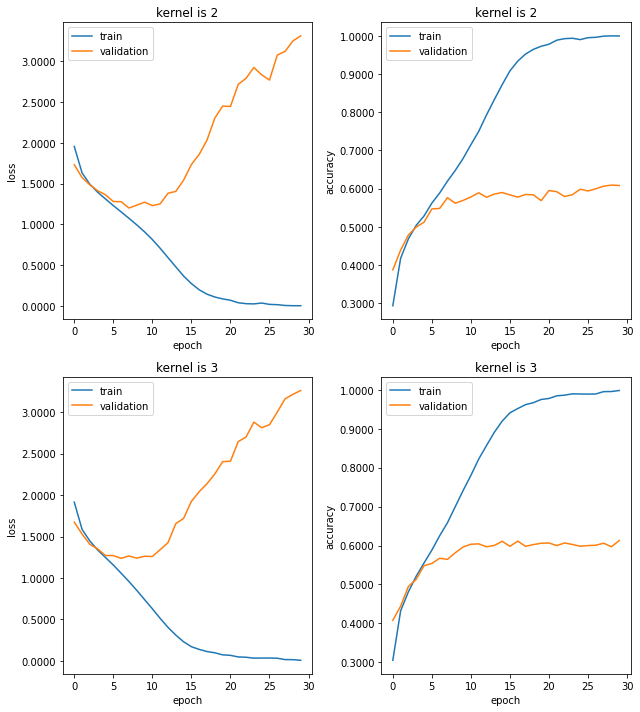

Best kernel is 3
Test data accuracy is 0.6103000044822693
Test data loss is 3.352001905441284


array([[655,  40,  66,  27,  19,   9,  21,  24,  81,  58],
       [ 23, 731,  16,  13,   5,   8,   8,   6,  30, 160],
       [ 56,  10, 503,  84, 106,  75,  72,  53,  22,  19],
       [ 19,  23,  87, 424,  78, 177,  97,  41,  21,  33],
       [ 30,   7, 105,  78, 509,  52,  93,  98,  17,  11],
       [ 13,   9,  86, 175,  70, 513,  37,  64,  16,  17],
       [ 11,  13,  57,  78,  64,  34, 698,  12,  13,  20],
       [ 20,  12,  32,  69,  67,  74,  14, 674,   8,  30],
       [111,  62,  22,  21,  11,  10,  15,   4, 695,  49],
       [ 44, 110,  16,  24,  12,  15,  13,  24,  41, 701]])

In [14]:
scores = []
losses = []
histories = []
for k in kernel:
  cnn_mlp = CNN_MLP()
  cnn_mlp.add_cnn(best_filter, k)
  cnn_mlp.add_mlp(best_act, '')
  cnn_mlp.Compile(best_op, best_loss)
  histories.append(cnn_mlp.Fit(x_train_CNN, y_train_CNN, epochs=30,
                               batch_size=best_bs, validation_split=0.2))
  acloss = cnn_mlp.Evaluate(x_test_CNN, y_test_CNN, batch_size=128)
  losses.append(acloss[0])
  scores.append(acloss[1])
Plot_Accuracy(histories, kernel, 'kernel')
best_kernel = kernel[scores.index(max(scores))]
print(f'Best kernel is {best_kernel}')
print(f'Test data accuracy is {max(scores)}')
print(f'Test data loss is {losses[scores.index(max(scores))]}')
confusion_matrix(Convert_To_Label(y_test_CNN), Convert_To_Label(cnn_mlp.Predict(x_test_CNN)))

##2) Pooling and Batch Normalization

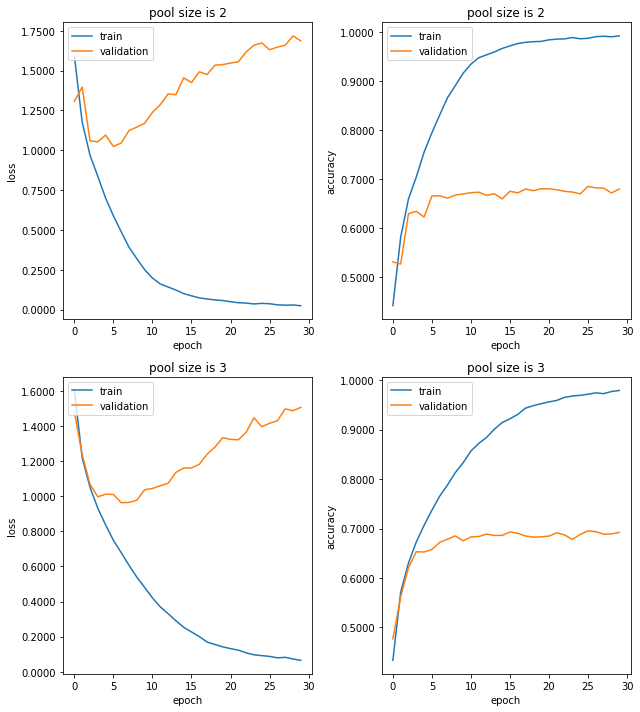

Best pool size is 3
Test data accuracy is 0.6851000189781189
Test data loss is 1.5079989433288574


array([[734,  28,  51,   9,  26,  17,  15,  10,  62,  48],
       [ 25, 784,  13,   7,   7,   5,  14,   6,  37, 102],
       [ 66,   4, 628,  68,  71,  61,  56,  26,  12,   8],
       [ 22,  11, 118, 486,  80, 153,  56,  36,  17,  21],
       [ 25,   6, 133,  59, 592,  35,  52,  70,  19,   9],
       [ 15,   7,  87, 167,  58, 573,  27,  44,   8,  14],
       [ 10,   5,  59,  61,  36,  38, 771,  10,   7,   3],
       [ 22,  13,  52,  40,  70,  75,  10, 693,   2,  23],
       [ 58,  36,  18,  14,   9,   9,   9,   4, 791,  52],
       [ 32,  70,  16,  13,   7,  12,   2,  21,  28, 799]])

In [15]:
scores = []
losses = []
histories = []
for p in pool_size:
  cnn_mlp = CNN_MLP()
  cnn_mlp.add_pooling_batch(best_filter, best_kernel, p)
  cnn_mlp.add_mlp(best_act, 'pooling')
  cnn_mlp.Compile(best_op, best_loss)
  histories.append(cnn_mlp.Fit(x_train_CNN, y_train_CNN, epochs=30,
                               batch_size=best_bs, validation_split=0.2))
  acloss = cnn_mlp.Evaluate(x_test_CNN, y_test_CNN, batch_size=128)
  losses.append(acloss[0])
  scores.append(acloss[1])
Plot_Accuracy(histories, pool_size, 'pool size')
best_pool = pool_size[scores.index(max(scores))]
print(f'Best pool size is {best_pool}')
print(f'Test data accuracy is {max(scores)}')
print(f'Test data loss is {losses[scores.index(max(scores))]}')
confusion_matrix(Convert_To_Label(y_test_CNN), Convert_To_Label(cnn_mlp.Predict(x_test_CNN)))

##3) Dropout

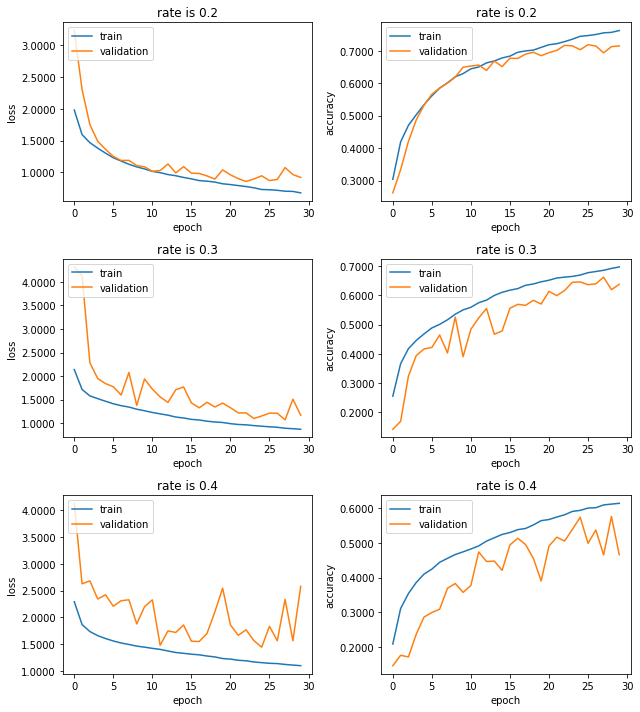

Best rate is 0.2
Test data accuracy is 0.7077000141143799
Test data loss is 0.9138947129249573


array([[422,  24,  60,   0,  21,   1,  96,   2, 371,   3],
       [ 13, 651,   3,   0,   4,   0, 137,   0, 171,  21],
       [ 77,  11, 364,  14,  76,  16, 338,   3,  97,   4],
       [ 19,   8, 109,  98,  47,  25, 539,   6, 144,   5],
       [ 30,   6, 131,   9, 383,   3, 377,   2,  59,   0],
       [ 12,   5, 129, 103,  50, 118, 422,  14, 144,   3],
       [  4,   1,  30,   2,   7,   0, 925,   1,  30,   0],
       [ 39,   9,  76,  14, 216,  15, 227, 337,  54,  13],
       [ 26,  11,   9,   0,   5,   0,  46,   1, 899,   3],
       [ 19, 185,   8,   2,   7,   1, 194,   4, 156, 424]])

In [16]:
scores = []
losses = []
histories = []
for r in rate:
  cnn_mlp = CNN_MLP()
  cnn_mlp.add_dropout(best_filter, best_kernel, best_pool, r)
  cnn_mlp.add_mlp(best_act, 'dropout', r)
  cnn_mlp.Compile(best_op, best_loss)
  histories.append(cnn_mlp.Fit(x_train_CNN, y_train_CNN, epochs=30,
                               batch_size=best_bs, validation_split=0.2))
  acloss = cnn_mlp.Evaluate(x_test_CNN, y_test_CNN, batch_size=128)
  losses.append(acloss[0])
  scores.append(acloss[1])
Plot_Accuracy(histories, rate, 'rate')
best_rate = rate[scores.index(max(scores))]
print(f'Best rate is {best_rate}')
print(f'Test data accuracy is {max(scores)}')
print(f'Test data loss is {losses[scores.index(max(scores))]}')
confusion_matrix(Convert_To_Label(y_test_CNN), Convert_To_Label(cnn_mlp.Predict(x_test_CNN)))

##4) Early Stopping

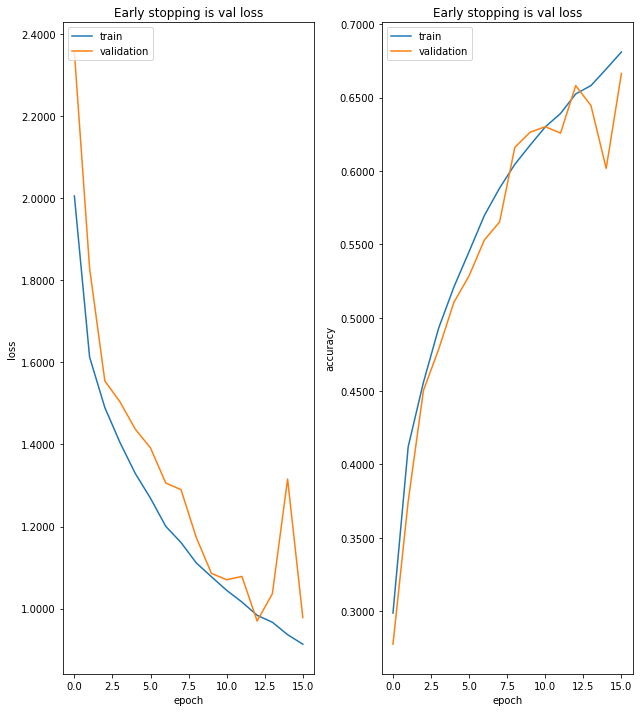

Test data accuracy is 0.6672999858856201
Test data loss is 0.9816126823425293


array([[642,   7,  81,  21,  45,   4,  30,   5, 140,  25],
       [ 29, 688,  14,  16,  15,   5,  42,   1,  89, 101],
       [ 51,   1, 466,  67, 211,  77,  87,  15,  22,   3],
       [ 11,   3,  76, 522, 113, 165,  73,  17,  14,   6],
       [ 16,   1,  33,  56, 759,  28,  64,  26,  17,   0],
       [  5,   0,  51, 217,  81, 571,  36,  27,  10,   2],
       [  4,   0,  27,  70,  65,  18, 807,   3,   6,   0],
       [  9,   1,  51,  40, 151,  90,  15, 629,   6,   8],
       [ 50,  16,  16,  15,  15,   3,  12,   1, 857,  15],
       [ 28,  53,   9,  28,  24,   9,  19,  15,  83, 732]])

In [40]:
histories = []
es = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=0)
cnn_mlp = CNN_MLP()
cnn_mlp.add_dropout(best_filter, best_kernel, best_pool, best_rate)
cnn_mlp.add_mlp(best_act, 'dropout', best_rate)
cnn_mlp.Compile(best_op, best_loss)
histories.append(cnn_mlp.Fit(x_train_CNN, y_train_CNN, epochs=30,
                             batch_size=best_bs, validation_split=0.2, callback=[es]))
Plot_Accuracy(histories, ['val loss'], 'Early stopping')
acloss = cnn_mlp.Evaluate(x_test_CNN, y_test_CNN, batch_size=128)
print(f'Test data accuracy is {acloss[1]}')
print(f'Test data loss is {acloss[0]}')
confusion_matrix(Convert_To_Label(y_test_CNN), Convert_To_Label(cnn_mlp.Predict(x_test_CNN)))